In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

In [2]:
# f1,f2 = frequency range (fmin, fmax)
# oct = freqeucny gap (oct = 1./3.; oct = 1./6.; oct = 1./12.)
# iom = output option (1 = acceleration / 2 = relative displacement)
# irdu = output unit (1=inch / 2=mm)
# bex = fatigue exponent

def th2fds_tom(t1,th1,f1,f2,oct,iom,irdu,bex):
    dt = t1[1]-t1[0]; sr = 1/dt;
    a,b,num,dur=t1,th1,len(th1),max(t1);    
    damp = 0.05;
    Q = 1/(2*damp);
    nt=int(0.8*(1/f1)/dt);
    resp=np.zeros(num);  fn=np.zeros(num);
    fn[0]=f1    
    for j in range(1,999):
        fn[j]=fn[j-1]*(2.**oct)
        if  fn[j] > sr/6. or fn[j] > f2:
            break
    
    num_fn=j+1;
    
    temp=fn[0:num_fn]
    del(fn)
    fn=temp
    del(temp)
    
    pv_pos=np.zeros(num_fn)
    pv_neg=np.zeros(num_fn)
    rd_pos=np.zeros(num_fn)
    rd_neg=np.zeros(num_fn)
    def a_coeff(omega,damp,dt): 
        ac=np.zeros(3)    
        ac[0]=1   
        omegad=omega*np.sqrt(1.-(damp**2))        
        E=np.exp(-damp*omega*dt)
        K=omegad*dt
        C=E*np.cos(K)
        ac[1]=-2*C
        ac[2]=+E**2    
        
        return ac
    def rainflow(resp,bex):
        
        num=len(resp)
    
        y=np.zeros(num,'f')
        a=np.zeros(num,'f')
        B=np.zeros((num,4),'f')
    
        y=resp
        k=0
        a[0]=y[0]
    
        k=1
    
        for i in range (1,(num-1)):
            
            slope1=(  y[i]-y[i-1])
            slope2=(y[i+1]-y[i])
    
            if((slope1*slope2)<=0):
                a[k]=y[i]
                k+=1
                 
        last_a=k        
        hold=last_a        
        a[k]=y[num-1]
    
        mina=min(a)
        maxa=max(a)
    
        nmm=int(maxa-mina)+1
    
        n=0
        i=0
        j=1
    
        sum=0
        kv=0
    
        ymax=-1.0e+20
    
        aa=a.tolist()
    
        nkv=0
    
        ijk=0
        LLL=int(0.2*float(hold/2))
    
        while(1):
    
    
            Y=abs(aa[i]-aa[i+1])
            X=abs(aa[j]-aa[j+1])
    
    
            if(X>=Y and Y>0):		
                if(Y>ymax):
                    ymax=Y
             
                if(i==0):		
                    n=0
                    sum+=0.5
                    B[kv][3]=aa[i+1]
                    B[kv][2]=aa[i]
                    B[kv][1]=0.5
                    B[kv][0]=Y
                    kv+=1
                    aa.pop(i)
                    last_a-=1
                    i=0
                    j=1    
                
                else:      
                    sum+=1
                    B[kv][3]=aa[i+1]
                    B[kv][2]=aa[i]
                    B[kv][1]=1.
                    B[kv][0]=Y
                    kv+=1	
    
                    n=0
                
                    aa.pop(i+1)
                    aa.pop(i)                
                
                    i=0
                    j=1
    
                    last_a-=2
            
                    nkv+=1
    
    
                    ijk+=1  
    
                    if(ijk==LLL):
                        ijk=0               
            else:
                i+=1
                j+=1
                
            if((j+1)>last_a):
                break                
    
    
        for i in range (0,last_a):
            Y=(abs(aa[i]-aa[i+1]))
    
            if(Y>0):
                sum+=0.5
                B[kv][3]=aa[i+1]
                B[kv][2]=aa[i]
                B[kv][1]=0.5
                B[kv][0]=Y
        
                kv+=1
    
            damage=0
    
            for i in range (0,kv+1):
       
               Y=B[i][0]
               damage+=B[i][1]*((Y/2.)**bex)        
        
        
        return damage
    def accel_SRS(num_fn,fn,damp,dt):
        
        pos    = np.zeros(num_fn)
        neg    = np.zeros(num_fn)
        damage = np.zeros(num_fn)        
        bc     = np.zeros(3)  
        
        for j in range(0,num_fn):
            
            omega=2.*np.pi*fn[j]
            omegad=omega*np.sqrt(1.-(damp**2))
        #
        #  bc coefficients are applied to the excitation
            
            E=np.exp(-damp*omega*dt)
            K=omegad*dt
            C=E*np.cos(K)
            S=E*np.sin(K)
            Sp=S/K
    
            bc[0]=1.-Sp
            bc[1]=2.*(Sp-C)
            bc[2]=E**2-Sp
                        
            ac=a_coeff(omega,damp,dt);
    
      
            resp=lfilter(bc, ac, b, axis=-1, zi=None)            
    
            pos[j]= max(resp)
            neg[j]= abs(min(resp))    
            
            damage[j]=rainflow(resp,bex);
            
            ma=max(abs(resp))
            
            # print(" %8.4g \t %8.4g \t %8.4g " %(fn[j],ma,damage[j]))
            
        return pos,neg,damage
    def rel_disp_SRS(num_fn,fn,damp,dt,irdu):
        
        rd_pos = np.zeros(num_fn)
        rd_neg = np.zeros(num_fn)
        damage = np.zeros(num_fn)        
        ac     = np.zeros(3)
        bc     = np.zeros(3)
                 
       
        for j in range(0,num_fn):
            
            omega=2.*np.pi*fn[j]
            omegad=omega*np.sqrt(1.-(damp**2))            
            
            E =np.exp(  -damp*omega*dt)
            E2=np.exp(-2*damp*omega*dt)
             
            K=omegad*dt
            C=E*np.cos(K)
            S=E*np.sin(K)
            
            Omr=(omega/omegad)
            Omt=omega*dt
            
            P=2*damp**2-1
            
            b00=2*damp*(C-1)
            b01=S*Omr*P
            b02=Omt
            
            b10=-2*Omt*C
            b11= 2*damp*(1-E2)
            b12=-2*b01   
    
            b20=(2*damp+Omt)*E2
            b21= b01
            b22=-2*damp*C               
            
            bc[0]=b00+b01+b02
            bc[1]=b10+b11+b12
            bc[2]=b20+b21+b22
            
            bc=-bc/(omega**3*dt)
                        
            ac=a_coeff(omega,damp,dt)
            
            resp=lfilter(bc, ac, b, axis=-1, zi=None)
            
            if(irdu==1):
                resp*=386
            else:
                resp*=9.81*1000
    
            rd_pos[j]= max(resp)
            rd_neg[j]= abs(min(resp))   
            
            damage[j]=rainflow(resp,bex);
            
            ma=max(abs(resp))
            
            # print(" %8.4g \t %8.4g \t %8.4g " %(fn[j],ma,damage[j]))
            
        return rd_pos,rd_neg,damage   
    if(iom==1):
        fp=np.zeros(num_fn);
        x_pos,x_neg,damage=accel_SRS(num_fn,fn,damp,dt);
    if(iom==2):
        rd_pos,rd_neg,damage=rel_disp_SRS(num_fn,fn,damp,dt,irdu);
        
    return fn,damage

In [4]:
f = open('full.txt','r',encoding='utf-8-sig');
lines = f.readlines();
data = [];
for i in range(len(lines)):
    data.append(lines[i].split('\t'));
data = np.array(data).astype(np.float)
t1 = data[:,0]; th1 = data[:,1];
f.close();

In [5]:
f1,f2,oct,iom,irdu,bex = 1,1000,1./12.,2,1,4;
fn,damage = th2fds_tom(t1,th1,f1,f2,oct,iom,irdu,bex);

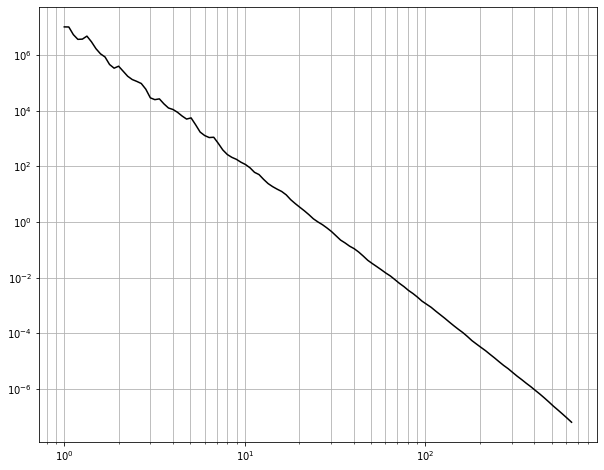

In [6]:
plt.figure(figsize=(10,8));
plt.loglog(fn,damage,'k-');
plt.grid(which='both');